In [ ]:
# No olvidar que en "google colab" hay que instalar qiskit

########################
# Instala versión 0.45.2
########################
# Importante, poner qiskit-aer en la misma linea de "pip install" para que coja la versión adecuada
try:
    import google.colab
    print("In colab, let's install things...")
    #
    !pip install qiskit[visualization]==0.45.2 qiskit-aer qiskit-ibm-runtime
except ImportError:
    print("NOT in colab")

<a id='sec_Notebooks_Circ_1_qubit'></a>
# Entrelazamiento _(Entanglement)_
$\newcommand{\ket}[1]{|#1\rangle}$

In [ ]:
from IPython.display import display, Latex, Markdown
from matplotlib import pyplot as plt
import scipy.linalg as la
import numpy as np

In [ ]:
from qiskit.circuit import QuantumRegister, ClassicalRegister,QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info import Statevector, schmidt_decomposition
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_qsphere, array_to_latex  

In [ ]:
# Utilería acumulada

# Definimos una función para visualizar el estado y la esfera a la vez
# Permite escalar la(s) esferas(s) con 'inches' pulgadas, si este parámetro
# no se pone, se dibuja al tamaño por defecto
# Si se pone 0, no se dibuja la esfera
def my_display_state_vector(psi, inches=None, prefix=r"|\psi\rangle = "):
    if isinstance(psi, Statevector):
        d_latex = psi.draw('latex', prefix=prefix)
        display(d_latex)
        #
        d_bloch = psi.draw('bloch')
        if isinstance(inches, (int,float)):
            if inches > 0:
                d_bloch.set_size_inches(inches, inches, forward=True)
                display(d_bloch)
        else:
            display(d_bloch)

#----------------------------------------------------------

# Función para simular un circuito con el método "statevector"
# Devuelve el resultado de la simulación
def my_circuit_simulate_statevector(qcirc, shots=1):
    # Instancia del simulador
    sim = AerSimulator(method = "statevector")
     
    # Hacemos una simulación y obtenemos los resultados
    qobj = transpile(qcirc, backend=sim)
    result = sim.run(qobj, shots=shots).result()
    
    return result
    
# Función para simular un circuito con el método "unitary"
# Devuelve el resultado de la simulación
def my_circuit_simulate_unitary(qcirc, shots=1):
    # Instancia del simulador
    sim = AerSimulator(method = "unitary")
     
    # Hacemos una simulación y obtenemos los resultados
    qobj = transpile(qcirc, backend=sim)
    result = sim.run(qobj, shots=shots).result()
    
    return result
    
#----------------------------------------------------------

# Función para obtener el vector de estado final de un cirucito dado
# usando la simulación de vector de estado.
# Devuelve esta tupla de 3 elementos:
#         (estado final, cuenta, resultado)
def my_get_circuit_state(qcirc_in, shots=1, final_probe=True):
    # Hacemos una copia ya que vamos a cambiar el objeto circuito
    qcirc = qcirc_in.copy()
    
    # Ponemos el "probe" para el vector de estado al final
    # del cirucito dado
    # ojo! el circuito no debe de tener un "save_statevector" ya!
    if final_probe:
        qcirc.save_statevector()
    
    # Hacemos una simulación y obtenemos los resultados
    result = my_circuit_simulate_statevector(qcirc, shots)
    state = None
    if final_probe:
        state = result.get_statevector()
    counts = result.get_counts()
    
    return state, counts, result

# Función para obtener la matriz unitaria final de un cirucito dado
# usando la simulación de matriz unitaria.
# Devuelve esta tupla de 2 elementos:
#         (unitary, resultado)
def my_get_circuit_unitary(qcirc_in, shots=1, final_probe=True):
    # Hacemos una copia ya que vamos a cambiar el objeto circuito
    qcirc = qcirc_in.copy()
    
    # Ponemos el "probe" para el vector de estado al final
    # del cirucito dado
    # ojo! el circuito no debe de tener un "save_statevector" ya!
    if final_probe:
        qcirc.save_unitary()
    
    # Hacemos una simulación y obtenemos los resultados
    result = my_circuit_simulate_unitary(qcirc, shots)
    unitary = result.get_unitary()
    
    return unitary, result


## Un juego no local _(a non-local game)_

El juego que se describe a continuación está basado en la descripción de las **desigualdades de Bell** de este [vídeo](https://youtu.be/UlLRzlpwq9E?feature=shared).


En este juego intervienen dos participantes, Alice (participante A) y Bob (participante B). Se trata de ver si el disponer de información cuántica entrelazada (en _entanglement_) puede proporcionar ventajas a la hora de ganar o no el juego. El juego se gana o pierde conjuntamente, es decir o los dos participantes ganan o los dos pierden.

El juego se ajusta a las siguientes reglas:
- Antes de comenzar el juego los participantes pueden discutir y establecer una estrategia

<!-- center>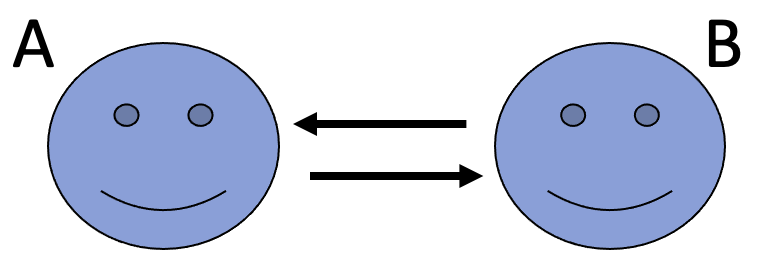</center-->

<center>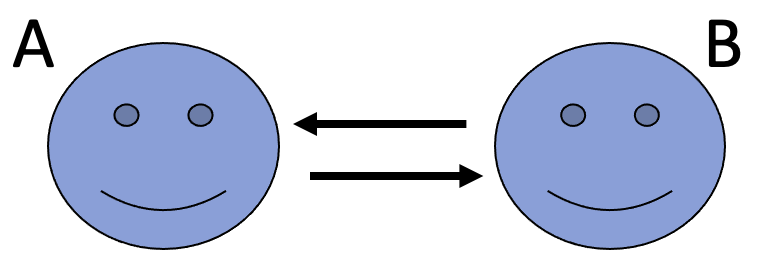</center>

- Una vez comenzado el juego, y durante toda su ejecución, los participantes no pueden comunicarse de ninguna manera.

<!-- center>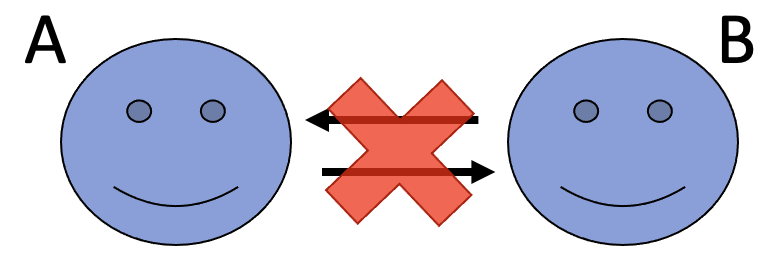</center-->

<center>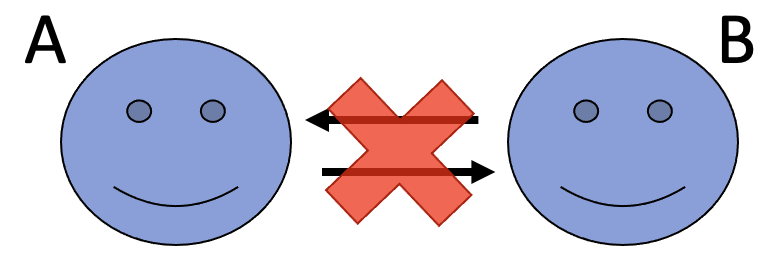</center>
  




- Un árbitro envía a cada participante un valor booleano aleatorio, llamémosles $x$ e $y$ respectivamente para A y B.

  Ningún participante tiene conocimiento alguno de lo que ha recibido el otro, ni puede comunicarse con él/ella en ningún momento.

  <!-- center>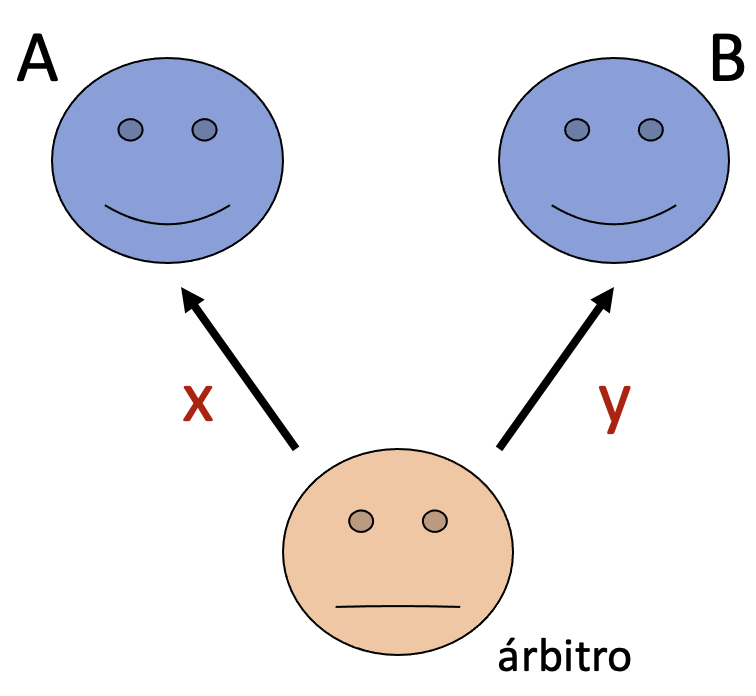</center -->

<center>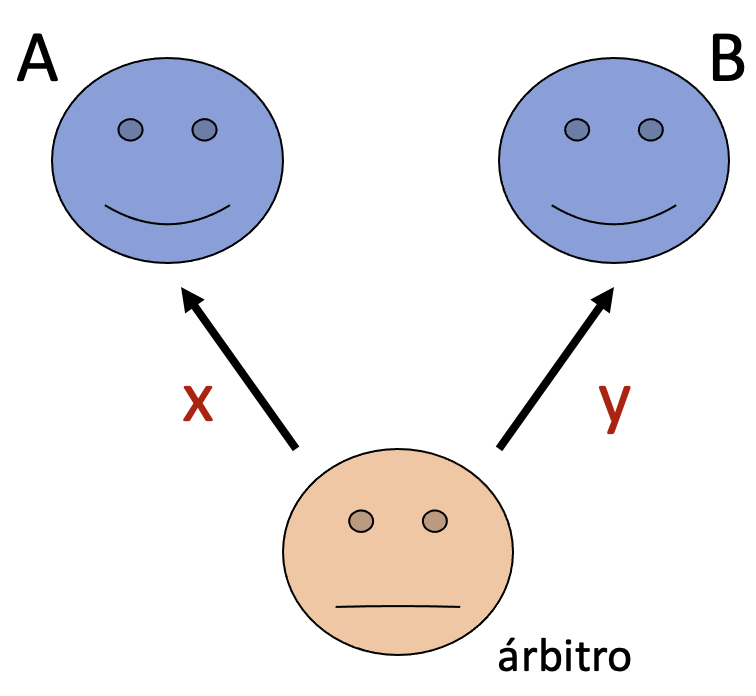</center>


- Cada participante recibido su valor, envía una respuesta que es también un valor booleano, al árbitro. Llamemos $a$ y $b$ a las respuestas respectivas de A y B. Estas respuestas pueden estar basadas en la estrategia pactada antes de empezar el juego.

  <!-- center>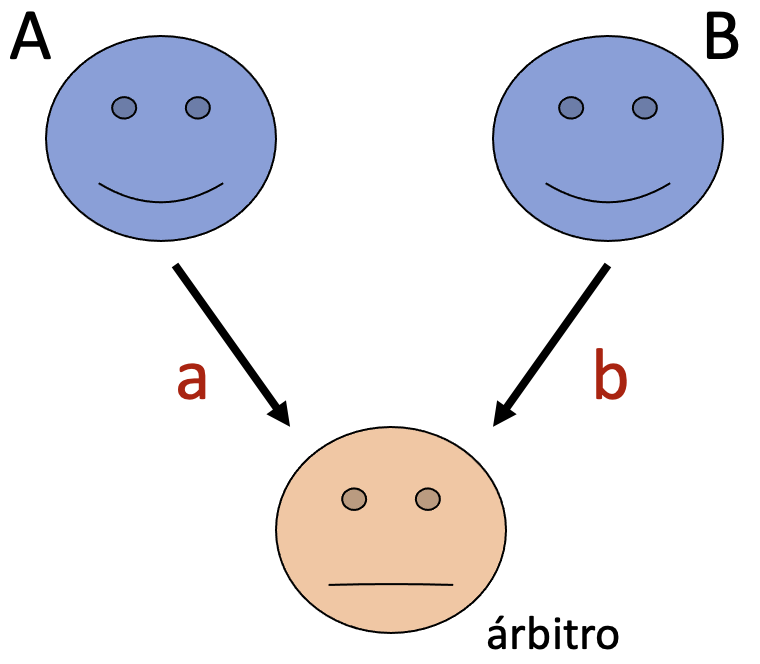</center -->

<center>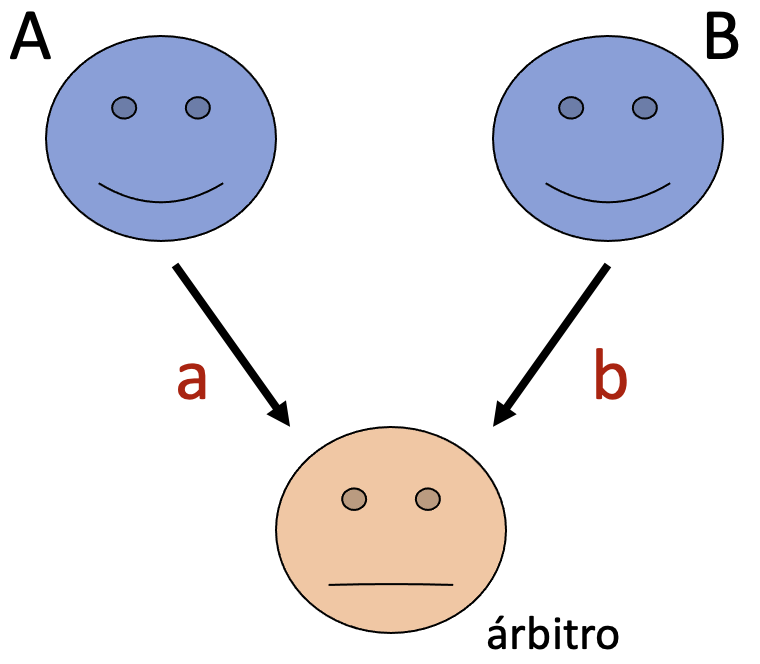</center>
  

 
- El árbitro, una vez recibida las respuestas computa una función ganadora, que si es cierta el juego se da por ganado. Dicha función ganadora es esta:

  $$ \boxed{ (a \oplus b ) = (x \wedge y)} $$

  donde $\oplus$ es la operación lógica OR-exclusiva, y $\wedge$ es la operación lógica AND.



---


In [ ]:
# Definamos antes de nada la función ganadora

def winfun(x,y,a,b):
    # Las siguientes operaciones son booleanas:
    # ^ = xor
    return (bool(a) ^ bool(b)) == (bool(x) and bool(y))

### El juego clásico

Definamos una estrategia por cada participante y una función que simule una partida del juego.

In [ ]:
# Definamos una estrategia
def estrategiaA(x):
    return 0

def estrategiaB(y):
    return 0

def juego(estrA, estrB):
    x = np.random.randint(0,2)
    y = np.random.randint(0,2)

    a = estrA(x)
    b = estrB(y)

    win = winfun(x,y, a,b)

    # print(f"A={a}, B={b}, x={x}, y={y}, win={win}") # debug
    return win

Ahora repitamos un buen número de partidas, y veamos con qué probabilidad se gana el juego.

In [ ]:
#%%time
N = 50000
nwin = 0
for i in range(0,N):
    nwin = nwin + juego(estrategiaA, estrategiaB)

pwin = nwin/N
display(Markdown(f"Probabilidad de ganar: **{pwin:.3f}**"))

Observando la tabla de verdad, vemos que no hay mejor estrategia que responder siempre $a=0$, $b=0$ (el resto de estrategias son iguales o peores en resultado).

Vemos que para este caso se tiene una probabilidad de ganar de $\frac{3}{4}=0.75=75\%$.

Podría decirse que este último valor es la **desigualdad de Bell** de este juego: **p(win) $\leq$ 0.75**

In [ ]:
#Tabla de verdad:
import pandas as pd

r = range(0,16)

x = [ (i & 0x8)>>3 for i in r]
y = [ (i & 0x4)>>2 for i in r]
a = [ (i & 0x2)>>1 for i in r]
b = [ (i & 0x1)    for i in r]

w = [ winfun(x[i], y[i], a[i], b[i]) for i in r]

es00 = [ "*" if ((not a[i]) and (not b[i])) else "" for i in r]

df = pd.DataFrame({
    "x": x,
    "y": y,
    "a": a,
    "b": b,
    "¿Gana?": w,
    "estrategia": es00
})

print(df)

### El juego cuántico

En nuestra versión cuántica, el juego se modifica ligeramente como se explica a continuación.

En primer lugar preparamos dos qubits entrelazados, por ejemplo en el estado de Bell $B_{00}$.

A cada participante se le entrega uno de los qubits antes de empezar el juego.

Cada participante puede manipular SU QUBIT a voluntad: puede aplicarle puertas de un qubit, las que desee y realizar mediciones sobre él (evidentemente  está prohibido aplicar puertas de dos o más qubit, ya que entendemos que A y B están separados y aislados uno con respecto al otro una vez que el juego comienza).

Alice y Bob plantean la siguiente estrategia antes de empezar a jugar:
- Alice dice "si recibo x=0, a MI QUBIT aplicaré una puerta de rotación Y de 0 radianes, y si recibo x=1, aplicaré una puerta de rotación Y de $\frac{-\pi}{2}$ radianes"
- Bob dice "estupendo, si recibo y=0, a MI QUTIT aplicaré una puerta de rotación Y de $\frac{-\pi}{4}$ radianes, y si recibo y=1 aplicaré una de rotación Y  de $\frac{\pi}{4}$ radianes"

Pactada la estrategia, el juego compienza entregando un qubit entrelazado del par $B_{00}$ a cada uno y procediendo como anteriormente se describió en el juego clásico. Al igual que antes, durante el transcurso del juego, la comunicación entre los participantes está prohibida.

In [ ]:
def win_count(c,x,y):
    # From a dictionary like {'00':1}
    # coming from a simulation count,
    # return the first (and unique) key
    # '00' as a number (assumed it's a string
    # using binary)

    W = 0
    for i in c.items():
        m = int(i[0], 2) # valores: '00'->0, '01'->1,...
        p = i[1]         # cuenta para ese par de bits
        a = m % 2        # ojo! a es el bit menos significativo
        b = m // 2
        W = W + p * winfun(x, y, a, b)  # veces que gana       
    
    return W

def simulaAB(x,y):
    quantum_reg_2_qubits = QuantumRegister(2, 'q') 
    classic_reg_2_bits = ClassicalRegister(2, 'c') 
    qc = QuantumCircuit(quantum_reg_2_qubits, classic_reg_2_bits)
    qc.h(0)
    qc.cx(0,1)

    if x == 0:
        theta = 0
    else:
        theta = -np.pi/2
    qc.ry(theta,0)

    if y == 0:
        theta = -np.pi/4
    else:
        theta = np.pi/4
    qc.ry(theta,1)
    
    qc.measure(quantum_reg_2_qubits, classic_reg_2_bits)
    #qc.measure(1,1)

    N = 10000
    s,c,v = my_get_circuit_state(qc, shots=N)

    display(qc.draw('text'))
    display(c)

    prob_ganar = win_count(c,x,y)/N

    print(f"Probabilidad de ganar (x={x}, y={y}): {prob_ganar}")

# Esta vez vamos a simular las 4 posibles
# combinaciones de valores que x e y pueden tener

simulaAB(0,0)
print()
simulaAB(0,1)
print()
simulaAB(1,0)
print()
simulaAB(1,1)
print()



Como se puede observar, para las 4 combinaciones
posibles de $x$ e $y$, posibles de $x$ e $y$, Alice y Bob **ganan** el juego con un porcentaje
**mayor al 75%**, que se había determinado para la situación _clásica_.

Al utilizar el par de qubits entrelazados, los jugadores han adquirido ventaja. **Se ha violado la desigualdad de Bell.**

<div style="background-color:#c8e6c9">
<hr>
<b>Ejercicio:</b>
    
Discute cómo en el caso de que los qubits entrelazados fueran **variables ocultas** no se obtendría ninguna ventaja.

Por ejemplo, imagínese que el par entrezadado, es un par de calcetines del mismo color (entrelazados en color, suelen venderse así). ¿Serviría de algo esta información, aunque ningún observador la conociera hasta que Alice y Bob comprobaran el color del calcetín?
<hr>
</div>

In [11]:
import qiskit
from qiskit_aer import AerSimulator
import qiskit.tools.jupyter
%qiskit_version_table